In [1]:
# Librerías necesarias
import pandas as pd
import sys
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1.Montaje Drive y paths

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!ls /content/drive/MyDrive


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 borrador_fernando_180624.ipynb  'Colab Notebooks'   P101   vida_laboral.pdf


In [3]:
# Mantengo el directorio de trabajo en Colab
WORKING_PATH = '/content'
%cd {WORKING_PATH}

/content


In [4]:
# Agrego Drive como un directorio adicional (sin cambiar el cwd)
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.append(DRIVE_PATH)


In [5]:
# Verificar mi direcorio de trabajo
!pwd  # Debería devolver "/content"


/content


In [6]:
# He subido el data set al Drive para no tener que cargarlo en colab cada vez que inicie sesión
# Compruebo que el archivo está .json está subido en Drive
!ls "{DRIVE_PATH}"

'02 - Spacy.ipynb'	     analisis_dataset_reviewsAmazon2.ipynb   requirements.txt
'03 - NLTK.ipynb'	     df_subset.csv			     Sports_and_Outdoors_5.json
'06 - Visualization.ipynb'   NLP_practica_EDA.ipynb		     Sports_and_Outdoors_5.json.gz


# 2.Descarga y exploración del corpus


## 2.1 Descarga del corpus

In [7]:
def parse(path):
  g = gzip.open(path, 'rb') # Abre el archivo gzip en modo binario de lectura
  for l in g:
    yield json.loads(l) # convierte la línea de JSON a un diccionario de Python

def getDF(path):
  i = 0
  df = {}
  for d in parse(path): # llamamos a la función parse() para obtener línea a línea
    df[i] = d # 'i' serán las claves del diccionario
    i += 1
  return pd.DataFrame.from_dict(df, orient='index') # convertie el diccionario a dataframe


In [8]:
df_full = getDF('/content/drive/MyDrive/Colab Notebooks/Sports_and_Outdoors_5.json.gz')

## 2.2 Exploración del corpus

In [9]:
df_full.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
0,5.0,True,"06 3, 2015",A180LQZBUWVOLF,0000032034,Michelle A,What a spectacular tutu! Very slimming.,Five Stars,1433289600,NaN,NaN,NaN
1,1.0,True,"04 1, 2015",ATMFGKU5SVEYY,0000032034,Crystal R,What the heck? Is this a tutu for nuns? I know...,Is this a tutu for nuns?!,1427846400,NaN,NaN,NaN
2,5.0,True,"01 13, 2015",A1QE70QBJ8U6ZG,0000032034,darla Landreth,Exactly what we were looking for!,Five Stars,1421107200,NaN,NaN,NaN
3,5.0,True,"12 23, 2014",A22CP6Z73MZTYU,0000032034,L. Huynh,I used this skirt for a Halloween costume and ...,I liked that the elastic waist didn't dig in (...,1419292800,NaN,NaN,NaN
4,4.0,True,"12 15, 2014",A22L28G8NRNLLN,0000032034,McKenna,This is thick enough that you can't see throug...,This is thick enough that you can't see throug...,1418601600,NaN,NaN,NaN


Para el proyecto NLP las características que me interesan son:
  - overall : indica el la puntuación en función de las estrellas asignadas
  - reviewText: indica el texto del usuario, lo utiliozaremos para el análisis de sentimiento

In [10]:
df_full = df_full[['overall', 'reviewText']]
df_full.head()

,overall,reviewText
0,5.0,What a spectacular tutu! Very slimming.
1,1.0,What the heck? Is this a tutu for nuns? I know...
2,5.0,Exactly what we were looking for!
3,5.0,I used this skirt for a Halloween costume and ...
4,4.0,This is thick enough that you can't see throug...


In [11]:
print(f'el shape del corpus es: {df_full.shape}')
print(f'el corpus tiene {df_full.shape[0]} filas y {df_full.shape[1]} columnas')
print('----------------------------------------------------------------------------------------')



el shape del corpus es: (2839940, 2)
el corpus tiene 2839940 filas y 2 columnas
----------------------------------------------------------------------------------------


In [12]:
# vemos si el dataset tiene valores nulos
df_full.isnull().sum()

,0
overall,0
reviewText,1114


In [13]:
# Eliminamos las instancias que tienen valores nulos
df_full.dropna(inplace=True)
df_full.isnull().sum()

,0
overall,0
reviewText,0


### 2.2.1 Distribución de reviews

Text(0, 0.5, 'Número de reviews')

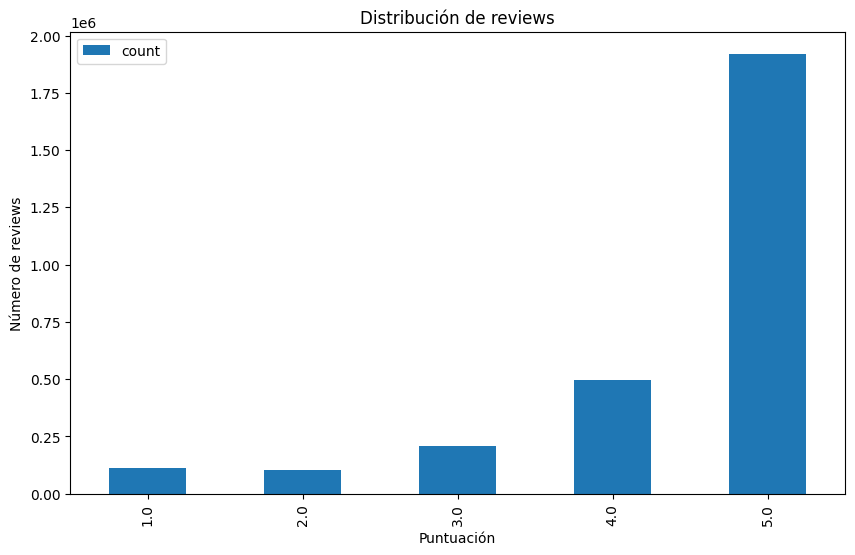

In [14]:
aux_df = pd.DataFrame(df_full['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Distribución de reviews', figsize=(10, 6))
aux_df.set_xlabel('Puntuación')
aux_df.set_ylabel('Número de reviews')

Conclusiones distribución de reviews:
  * Se observa muchas reviews positivas (de 4 y 5 estrellas) y pocas negativas (1,2, y 3)
  * Puede ser interesante hacer un subset estratificando por la categoría 'reviews'
  * Etiqueto a una clase binaria: Las reviews 1,2 y 3 como negativas(0) y 4 y 5 como positivas (1)

In [15]:
def label_sentiment(rating):
  if rating in [1,2,3]:
    return 0
  else:
    return 1

In [16]:
df_full['sentiment'] = df_full['overall'].apply(label_sentiment)
df_full.head()

,overall,reviewText,sentiment
0,5.0,What a spectacular tutu! Very slimming.,1
1,1.0,What the heck? Is this a tutu for nuns? I know...,0
2,5.0,Exactly what we were looking for!,1
3,5.0,I used this skirt for a Halloween costume and ...,1
4,4.0,This is thick enough that you can't see throug...,1


In [17]:
df_full['overall'].value_counts().sort_values(ascending=False)

,count
overall,
5.0,1920488
4.0,495400
3.0,210180
1.0,111129
2.0,101629


# Distribución de clases:
0 --> Sentimiento negativo
1 --> Sentimiento positivo

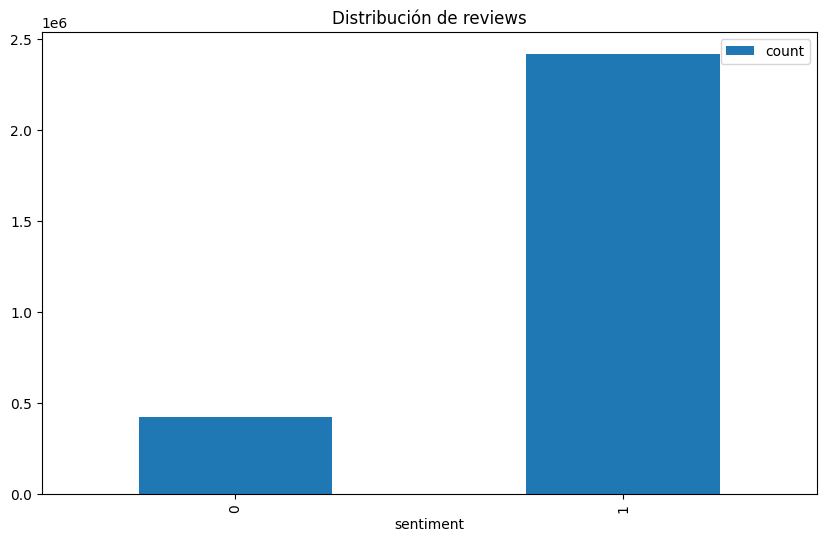

In [18]:
aux_df=pd.DataFrame(df_full['sentiment'].value_counts(sort=False).sort_index())
aux_df=aux_df.plot(kind='bar', title='Distribución de reviews', figsize=(10,6))

## 2.3 División del corpus en un subset

In [19]:


# Definir el tamaño del subset (por ejemplo, 30% del dataset original)
subset_size = 0.01

# Crear el subset manteniendo la proporción de 'overall'
df_subset, _ = train_test_split(df_full, train_size=subset_size, stratify=df_full['overall'], random_state=42)

# Verificar la distribución antes y después
print("Distribución original:")
print(df_full['overall'].value_counts(normalize=True))

print("\nDistribución en el subset:")
print(df_subset['overall'].value_counts(normalize=True))
print('----------------------------------------------------------------------------------------')
print(f'el shape del subset es: {df_subset.shape}')

Distribución original:
overall
5.0    0.676508
4.0    0.174509
3.0    0.074038
1.0    0.039146
2.0    0.035800
Name: proportion, dtype: float64

Distribución en el subset:
overall
5.0    0.676518
4.0    0.174510
3.0    0.074045
1.0    0.039136
2.0    0.035790
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------
el shape del subset es: (28388, 3)


In [20]:
df_subset.isnull().sum()

,0
overall,0
reviewText,0
sentiment,0


In [21]:
# Guardamos el subset en drive.
df_subset.to_csv('/content/drive/MyDrive/Colab Notebooks/df_subset.csv', index=False, encoding='utf-8', sep=',')

In [22]:
df_subset.head()

,overall,reviewText,sentiment
1779756,5.0,Nice big bag. Will keep clothes and devices dry!,1
108119,2.0,CHeap. Light. Small. Long enough for bike rack...,0
352200,5.0,"What can you say...they're ""bean"" bags... Corn...",1
1073462,5.0,"It's a pillow, and an animal. Outside of it be...",1
502372,5.0,What little girl doesn't love pink tennis ball...,1


# 3.Análisis Exploratorio del subset

## 3.1 Carga del subset

In [23]:

df_subset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_subset.csv', keep_default_na=False)

In [24]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28388 entries, 0 to 28387
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     28388 non-null  float64
 1   reviewText  28388 non-null  object 
 2   sentiment   28388 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 665.5+ KB


In [25]:
df_subset.isnull().sum()

,0
overall,0
reviewText,0
sentiment,0


## 3.2 Tokenización y transformaciones

In [26]:
import spacy

# Cargar modelo en ingles
nlp = spacy.load('en_core_web_sm')

# Función para visulizar en una tabla información de los token
def token_information(doc):
    # Cabecera
    header = '{:<10}{:<10}{:<10}{:<10}{:<20}'.format('Token', 'POS', 'Tag', 'Dep', 'Meaning')
    print(header)
    print('-' * len(header))

    for token in doc:
        meaning = spacy.explain(token.dep_) or 'N/A'
        print('{:<10}{:<10}{:<10}{:<10}{:<20}'.format(token.text, token.pos_, token.tag_, token.dep_, meaning))


In [27]:
# Función para procesar el texto e imprimir lo anterior
def process_and_display_token_info(text):
    doc = nlp(text)
    token_information(doc)

In [28]:
df_subset['reviewText'].head(5).apply(process_and_display_token_info)

Token     POS       Tag       Dep       Meaning             
------------------------------------------------------------
Nice      ADJ       JJ        amod      adjectival modifier 
big       ADJ       JJ        amod      adjectival modifier 
bag       NOUN      NN        ROOT      root                
.         PUNCT     .         punct     punctuation         
          SPACE     _SP       dep       unclassified dependent
Will      AUX       MD        aux       auxiliary           
keep      VERB      VB        ROOT      root                
clothes   NOUN      NNS       dobj      direct object       
and       CCONJ     CC        cc        coordinating conjunction
devices   NOUN      NNS       nsubj     nominal subject     
dry       ADJ       JJ        oprd      object predicate    
!         PUNCT     .         punct     punctuation         
Token     POS       Tag       Dep       Meaning             
------------------------------------------------------------
CHeap     PROPN   

,reviewText
0,None
1,None
2,None
3,None
4,None


In [29]:
# Elimino mediante regex los signos de puntuación.
import re

def remove_punctuation(text):

  text = str(text)
  text = re.sub(r'[^\w\s]', '', text)
  return text

df_subset['reviewText'] = df_subset['reviewText'].apply(remove_punctuation)
df_subset.head()

,overall,reviewText,sentiment
0,5.0,Nice big bag Will keep clothes and devices dry,1
1,2.0,CHeap Light Small Long enough for bike racks C...,0
2,5.0,What can you saytheyre bean bags Cornhole bags...,1
3,5.0,Its a pillow and an animal Outside of it being...,1
4,5.0,What little girl doesnt love pink tennis balls...,1


In [30]:
df_subset['reviewText'].head(5).apply(process_and_display_token_info)

Token     POS       Tag       Dep       Meaning             
------------------------------------------------------------
Nice      ADJ       JJ        amod      adjectival modifier 
big       ADJ       JJ        amod      adjectival modifier 
bag       NOUN      NN        nsubj     nominal subject     
          SPACE     _SP       dep       unclassified dependent
Will      AUX       MD        aux       auxiliary           
keep      VERB      VB        ROOT      root                
clothes   NOUN      NNS       dobj      direct object       
and       CCONJ     CC        cc        coordinating conjunction
devices   NOUN      NNS       conj      conjunct            
dry       VERB      VBP       oprd      object predicate    
Token     POS       Tag       Dep       Meaning             
------------------------------------------------------------
CHeap     PROPN     NNP       compound  compound            
Light     PROPN     NNP       compound  compound            
Small     PROPN   

,reviewText
0,None
1,None
2,None
3,None
4,None


In [31]:
#  concateno todas las reseñas de la columna 'reviewText' del subset en un solo string, separando cada reseña con un espacio.
corpus = df_subset['reviewText'].str.cat(sep=' ')
print(f'el corpus tiene {len(corpus)} caracteres')
print('----------------------------------------------------------------------------------------')
print(f'Ejemplo de las 100 primeros caracteres:')
print()
print(corpus[:99])

el corpus tiene 6772647 caracteres
----------------------------------------------------------------------------------------
Ejemplo de las 100 primeros caracteres:

Nice big bag  Will keep clothes and devices dry CHeap Light Small Long enough for bike racks Coils 


In [32]:
#Transformo todo el texto a minúsculas
corpus = corpus.lower()

In [33]:
from collections import Counter
# palabras mas comunes
def most_common(review, number):
  words_nltk = review.split()
  wf = Counter(words_nltk)
  return wf.most_common(number), words_nltk


In [34]:
most_common_words, words_nltk = most_common(corpus, 10)

In [35]:
most_common_words

[('the', 62296),
 ('and', 37855),
 ('i', 37834),
 ('a', 36028),
 ('to', 32854),
 ('it', 30622),
 ('for', 20472),
 ('is', 20398),
 ('this', 17683),
 ('of', 17354)]

Las palabras más comunes son stopwords. Vamos a quitarlas del corpus

In [36]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Función para eliminar stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and word not in ['one']]
    return " ".join(filtered_words)

corpus_without_stopwords = remove_stopwords(corpus)

print(f'el corpus sin stopwords tiene {len(corpus_without_stopwords)} caracteres')
print('----------------------------------------------------------------------------------------')
print(f'Ejemplo de las 100 primeros caracteres:')
print()
print(corpus_without_stopwords[:99])

# Recalcular las palabras más comunes después de eliminar las stopwords
most_common_words_no_stopwords, words_nltk_no_stopwords = most_common(corpus_without_stopwords, 10)
most_common_words_no_stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


el corpus sin stopwords tiene 4355163 caracteres
----------------------------------------------------------------------------------------
Ejemplo de las 100 primeros caracteres:

nice big bag keep clothes devices dry cheap light small long enough bike racks coils snuggly frame 


[('great', 8516),
 ('good', 5998),
 ('well', 5361),
 ('use', 4926),
 ('like', 4922),
 ('would', 4072),
 ('get', 3536),
 ('product', 3144),
 ('fit', 3136),
 ('nice', 2986)]

## 3.3 Visualizaciones (n-gramas y word cloud)

In [37]:
# Análissi de n-grams
from nltk import ngrams

In [38]:
bigrams_ = list(ngrams(most_common_words_no_stopwords, 2))
trigrams_ = list(ngrams(most_common_words_no_stopwords, 3))

In [39]:
bigrams_[:10]

[(('great', 8516), ('good', 5998)),
 (('good', 5998), ('well', 5361)),
 (('well', 5361), ('use', 4926)),
 (('use', 4926), ('like', 4922)),
 (('like', 4922), ('would', 4072)),
 (('would', 4072), ('get', 3536)),
 (('get', 3536), ('product', 3144)),
 (('product', 3144), ('fit', 3136)),
 (('fit', 3136), ('nice', 2986))]

In [40]:
trigrams_[:10]

[(('great', 8516), ('good', 5998), ('well', 5361)),
 (('good', 5998), ('well', 5361), ('use', 4926)),
 (('well', 5361), ('use', 4926), ('like', 4922)),
 (('use', 4926), ('like', 4922), ('would', 4072)),
 (('like', 4922), ('would', 4072), ('get', 3536)),
 (('would', 4072), ('get', 3536), ('product', 3144)),
 (('get', 3536), ('product', 3144), ('fit', 3136)),
 (('product', 3144), ('fit', 3136), ('nice', 2986))]

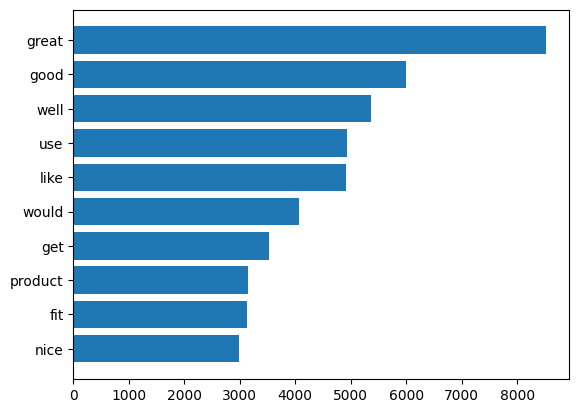

In [41]:
# Visualización diagrama de barras
words = [w[0] for w in most_common_words_no_stopwords]
freqs = [w[1] for w in most_common_words_no_stopwords]

freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()


In [42]:

!pip install wordcloud
from wordcloud import WordCloud

In [43]:
# Nube de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

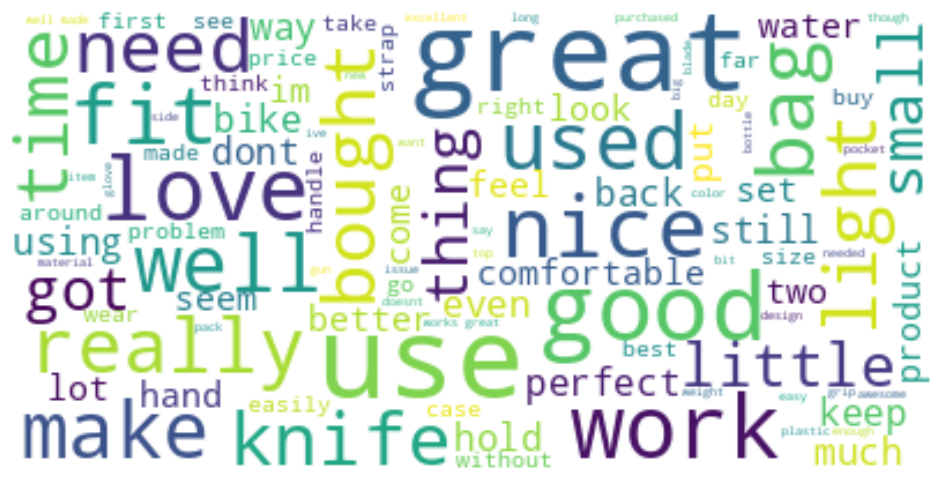

In [44]:
list_words = words_nltk_no_stopwords
plot_word_cloud(list_words)

In [45]:
from spacy import displacy
doc = nlp(corpus[:100000])
displacy.render(doc, style='ent', jupyter=True, options={'distance':100})

In [46]:
print('{0:10}{1:10}'.format('Token', 'Entity Label'))
for entity in doc.ents:
    print('{0:10}{1:10}'.format(entity.text, entity.label_))

Token     Entity Label
the 1 protrudesDATE      
a few secondsTIME      
this a few months from nowDATE      
minnesota GPE       
126       CARDINAL  
22        CARDINAL  
one       CARDINAL  
about halfCARDINAL  
joe       PERSON    
the summerDATE      
13yearold CARDINAL  
one       CARDINAL  
4         CARDINAL  
5         CARDINAL  
25        CARDINAL  
a day     DATE      
two       CARDINAL  
three     CARDINAL  
one       CARDINAL  
11        CARDINAL  
three     CARDINAL  
under 20  DATE      
first     ORDINAL   
several monthsDATE      
2 inch    QUANTITY  
two       CARDINAL  
years     DATE      
two       CARDINAL  
1022      DATE      
one       CARDINAL  
22lr      CARDINAL  
first     ORDINAL   
1         CARDINAL  
years     DATE      
1         CARDINAL  
today     DATE      
10200     DATE      
2535      DATE      
1         CARDINAL  
one       CARDINAL  
the past few weeksDATE      
about 20  CARDINAL  
3 days    DATE      
90 degreesQUANTITY  
3 days    DATE   

## 3.4 Embeddings

### 3.4.1 carga del subset

In [47]:

df_subset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_subset.csv', keep_default_na=False)

In [48]:
df_subset.head()

,overall,reviewText,sentiment
0,5.0,Nice big bag. Will keep clothes and devices dry!,1
1,2.0,CHeap. Light. Small. Long enough for bike rack...,0
2,5.0,"What can you say...they're ""bean"" bags... Corn...",1
3,5.0,"It's a pillow, and an animal. Outside of it be...",1
4,5.0,What little girl doesn't love pink tennis ball...,1


In [50]:
df_subset.isnull().sum()
df_subset.shape

(28388, 3)

### 3.4.2 Limpieza subset

In [51]:
import pandas as pd
import spacy
import re

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

from collections import defaultdict

from time import time
import logging  # Configuración de loggings para monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [52]:
# FUNCION DE LIMPIEZA
nlp = spacy.load("en_core_web_sm")
def cleaning(doc):
    #Lematizar y quitar stop words
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Eliminar tokes con longitud menor a 2
    if len(txt) > 2:
        return ' '.join(txt)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [53]:
# Quitamos los caracteres no alfabétivos de los textos
review_clean = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in  df_subset['reviewText'])

In [54]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(review_clean, batch_size=5000)]

print('Tiempo para limpiar todo: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para limpiar todo: 2.72 mins


Organizams el resultado en un data frame, tratando los posibles valores faltantes y dupicados

In [55]:
df_clean_subset = pd.DataFrame({'clean': txt})
df_clean_subset = df_clean_subset.dropna().drop_duplicates()
df_clean_subset.shape

(24219, 1)

### 3.4.3 Guardamos achivo limpio

In [56]:
df_clean_subset.to_csv('/content/drive/MyDrive/Colab Notebooks/df_clean_subset.csv')

### 3.4.4 Entreno del modelo

In [57]:
import multiprocessing

from gensim.models import Word2Vec

In [58]:
# Número de cores del ordenador
cores = multiprocessing.cpu_count()
print (cores)

2


In [59]:
# Definimos los hiperparámetros
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=100,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [60]:
# Construimos vocabulario
t = time()
sent = [row.split() for row in df_clean_subset['clean']]
w2v_model.build_vocab(sent, progress_per=10000)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para construir el vocabulario: 0.0 mins


In [61]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Vocabulario compuesto por 2843 palabras


In [62]:
#entrenamos modeo word2Vect
t = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.57 mins


In [63]:
# Guardamos el modelo
w2v_model.save('/content/drive/MyDrive/Colab Notebooks/w2v_model.model')

In [66]:
# Visualización de palabras similares
w2v_model.wv.most_similar(positive=["great"])

[('good', 0.7093678116798401),
 ('awesome', 0.644479513168335),
 ('nice', 0.6392328143119812),
 ('perfect', 0.6337358355522156),
 ('excellent', 0.6083682179450989),
 ('love', 0.5322670340538025),
 ('like', 0.5195975303649902),
 ('fantastic', 0.510670006275177),
 ('outstanding', 0.5105292797088623),
 ('brilliant', 0.4371195137500763)]

In [67]:
w2v_model.wv.most_similar(positive=["sport"])

[('bra', 0.6155660152435303),
 ('recreational', 0.6135651469230652),
 ('league', 0.6125745177268982),
 ('active', 0.6027430295944214),
 ('volleyball', 0.583013117313385),
 ('soccer', 0.5670621395111084),
 ('team', 0.5481196045875549),
 ('favorite', 0.5210441946983337),
 ('school', 0.5137447118759155),
 ('travel', 0.512978732585907)]

### 3.4.5 Clústers
Al haber mucha puntuación positiva, voy a tratar de clusterizar las opiniones negtivas. Palabras similares a 'horrible' y 'bad'

In [68]:
keys = ['horrible','bad','great']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [69]:
print(word_clusters)

[['terrible', 'whatsoever', 'explain', 'ridiculous', 'idiot', 'maybe', 'email', 'theirs', 'miss', 'direct'], ['guess', 'think', 'maybe', 'try', 'lol', 'happen', 'know', 'stupid', 'seriously', 'terrible'], ['good', 'awesome', 'nice', 'perfect', 'excellent', 'love', 'like', 'fantastic', 'outstanding', 'brilliant']]


### 3.4.6 Reducción de dimensionalidad 2D

In [70]:
import numpy as np
from sklearn.manifold import TSNE


tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


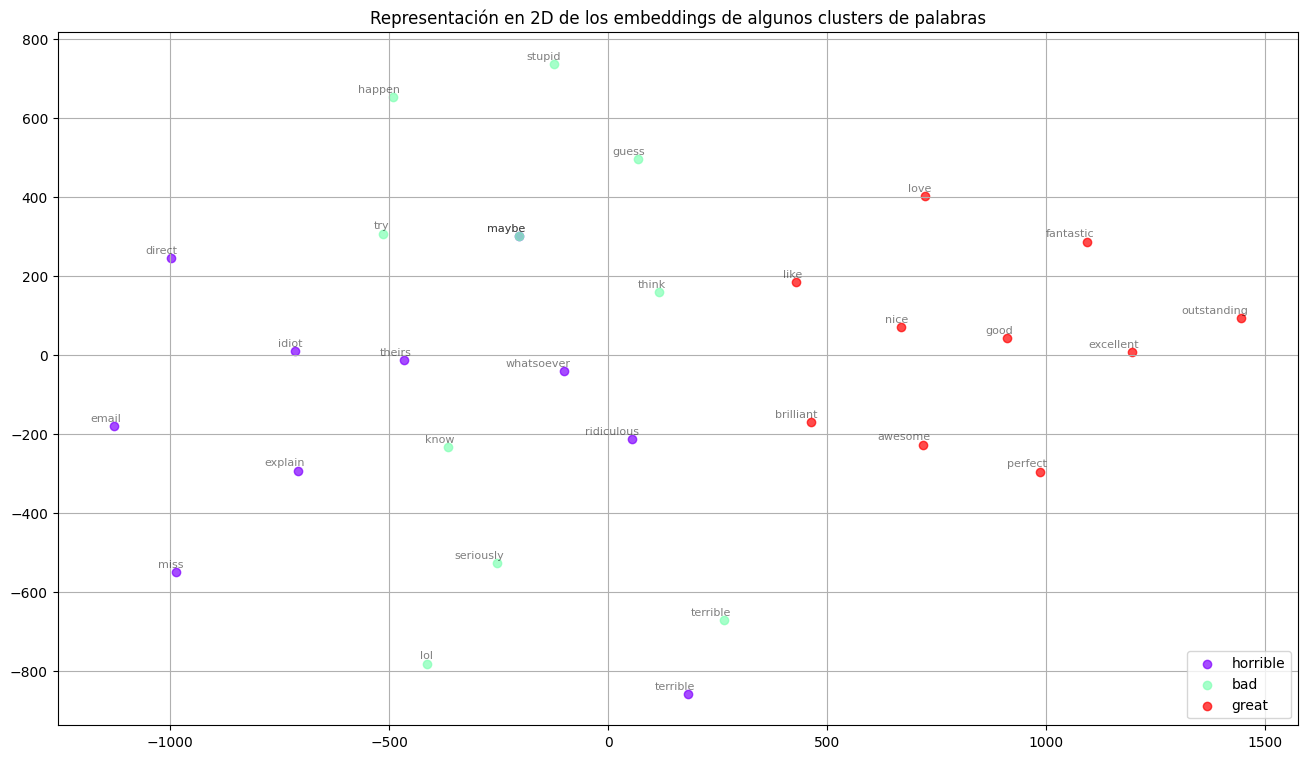

In [71]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)